In [1]:
import pandas as pd
import math
import datetime as dt
import time
import json
import numpy as np
import warnings
import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

import torch
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import sklearn
from sklearn import svm

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
from Sleep_Stress_new_features import preprocessing

#  No call nor sms data

In [3]:
uid_list = ['u00', 'u01', 'u02', 'u03', 'u04', 'u07', 'u08', 'u09', 'u10', 'u12', #'u13',
            'u14', 'u15', 'u16', 'u17',
      'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 
      'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47','u49', 'u50', 'u51', 'u52', 'u53', 'u54', 'u56', 
      'u57', 'u58' ,'u59']

dataframes = []
for uid in uid_list:
    try:
        df = preprocessing(uid)
        dataframes.append((uid, df))
        print(uid, len(df))
    except:
        pass

u00 10
u02 7
u08 25
u12 7
u24 8
u31 2
u36 12
u46 6
u47 1
u49 5
u50 0
u51 6
u54 3
u56 0
u57 13
u58 14
u59 35


# Predicting Stress and Sleep:

In [4]:
def transform_df(dataframe):
    ## obtain the dates as a column and re-index the dataframes
    re_index_data = []

    for tup in dataframe:
        test = tup[1]
        test = test.rename_axis('date').reset_index()
        re_index_data.append((tup[0], test))
    return re_index_data

In [5]:
transformed_data = transform_df(dataframes)

In [6]:
transformed_dataframes = [tup[1] for tup in transformed_data]

In [7]:
df3 = pd.concat(transformed_dataframes)
df3 = df3.sort_values(by='date')
max_range = len(df3)
df3 = df3.drop(['date', 'Std_stress_level', 'Median_stress_level',
               'Min_stress_level', 'Max_stress_level', 'Skew_stress_level',
               'Var_stress_level', 'Sum_stress_level'], axis=1)
df3 = df3.reset_index(drop=True)
df3

,Mean_Call_Duration,Std_Call_Duration,Median_Call_Duration,Min_Call_Duration,Max_Call_Duration,Skew_Call_Duration,Var_Call_Duration,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,...,Var_social_sleep,Mean_number_social,Std_number_social,Median_number_social,Min_number_social,Max_number_social,Skew_number_social,Var_number_social,Sum_number_social,Mean_stress_level
0,130.698587,202.457750,93.193093,0.000000,1002.000000,3.646713,4.098914e+04,0.294428,0.695228,0,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,4,1.0
1,66.195011,10.472734,69.168490,22.000000,69.168490,-3.704326,1.096782e+02,0.313521,0.806401,0,...,2.25,3.500000,0.500000,3.5,3,4,0.000000,0.250000,7,2.0
2,42.657215,17.618854,44.813694,0.000000,86.000000,-0.640929,3.104240e+02,0.132745,0.446104,0,...,0.00,2.333333,0.471405,2.0,2,3,1.732051,0.222222,7,2.0
3,140.230874,29.240159,146.327869,0.000000,146.327869,-4.898979,8.549869e+02,0.098508,0.426783,0,...,0.00,3.000000,0.000000,3.0,3,3,0.000000,0.000000,3,4.0
4,56.636066,0.000000,56.636066,56.636066,56.636066,0.000000,5.048710e-29,0.248774,0.692781,0,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,4,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,105.000000,0.000000,105.000000,105.000000,105.000000,0.000000,0.000000e+00,0.115609,0.493460,0,...,0.00,2.000000,0.000000,2.0,2,2,0.000000,0.000000,2,1.0
150,59.269622,23.318115,69.168490,0.000000,69.168490,-2.230664,5.437345e+02,0.101164,0.440019,0,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,8,2.0
151,221.186513,68.222805,243.621037,0.000000,253.000000,-2.788408,4.654351e+03,0.056297,0.312272,0,...,0.00,4.000000,0.000000,4.0,4,4,0.000000,0.000000,4,5.0
152,83.181532,99.097467,69.168490,0.000000,562.000000,4.765912,9.820308e+03,0.191936,0.580720,0,...,20.25,5.000000,0.000000,5.0,5,5,0.000000,0.000000,5,3.5


# Correlation Analysis:

In [8]:
correlation_df = df3.corr()
correlation_df

,Mean_Call_Duration,Std_Call_Duration,Median_Call_Duration,Min_Call_Duration,Max_Call_Duration,Skew_Call_Duration,Var_Call_Duration,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,...,Var_social_sleep,Mean_number_social,Std_number_social,Median_number_social,Min_number_social,Max_number_social,Skew_number_social,Var_number_social,Sum_number_social,Mean_stress_level
Mean_Call_Duration,1.000000,0.600767,0.971189,0.240523,0.600838,0.153295,0.533421,-0.098758,-0.091919,NaN,...,0.004384,-0.055537,0.043413,-0.053120,-0.062360,-0.049268,-0.028519,0.046049,-0.039284,0.141569
Std_Call_Duration,0.600767,1.000000,0.470475,-0.314732,0.976029,0.541088,0.874234,-0.009463,0.051395,NaN,...,0.036407,0.092426,0.131115,0.098137,0.070474,0.108652,-0.037537,0.134360,0.152044,0.027047
Median_Call_Duration,0.971189,0.470475,1.000000,0.251260,0.459081,0.026681,0.424854,-0.093369,-0.088264,NaN,...,-0.007422,-0.066069,0.035831,-0.065296,-0.071154,-0.060210,-0.014494,0.038258,-0.053368,0.155721
Min_Call_Duration,0.240523,-0.314732,0.251260,1.000000,-0.191497,-0.014408,-0.151385,-0.029511,-0.118113,NaN,...,0.000679,-0.149715,-0.045379,-0.148187,-0.142731,-0.154672,-0.032716,-0.046435,-0.099164,0.013683
Max_Call_Duration,0.600838,0.976029,0.459081,-0.191497,1.000000,0.590431,0.871173,-0.007401,0.042443,NaN,...,0.041182,0.084037,0.149707,0.091057,0.058807,0.102717,-0.052698,0.153154,0.162920,-0.000651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Max_number_social,-0.049268,0.108652,-0.060210,-0.154672,0.102717,0.009124,0.041642,0.374081,0.415735,NaN,...,0.192447,0.987692,0.185954,0.983847,0.953001,1.000000,0.036321,0.183617,0.614646,0.119982
Skew_number_social,-0.028519,-0.037537,-0.014494,-0.032716,-0.052698,-0.089742,-0.024373,0.219881,0.161068,NaN,...,-0.044661,-0.002772,0.059064,-0.064675,0.017137,0.036321,1.000000,0.054745,0.000151,-0.021173
Var_number_social,0.046049,0.134360,0.038258,-0.046435,0.153154,0.059437,0.207220,0.110249,0.120414,NaN,...,0.036831,0.030936,0.999643,0.032405,-0.122382,0.183617,0.054745,1.000000,0.494000,0.033896
Sum_number_social,-0.039284,0.152044,-0.053368,-0.099164,0.162920,0.157932,0.100232,0.501632,0.490016,NaN,...,0.109771,0.548137,0.501428,0.556857,0.464546,0.614646,0.000151,0.494000,1.000000,0.044823


In [9]:
## Investigate correlation analysis with only the label 

In [132]:
correlation_df['Mean_stress_level'].dropna().sort_values(ascending=False)[:20]

Mean_stress_level               1.000000
Sum_audio_inference             0.183413
number of distinct locations    0.180779
Median_Call_Duration            0.155721
Skew_conv_duration              0.147630
Mean_Call_Duration              0.141569
Min_phone_lock_duration         0.138713
Skew_Activity_inference         0.136932
Min_pic_id                      0.129735
Sum_Activity_inference          0.125903
Max_number_social               0.119982
Mean_number_social              0.117341
Median_number_social            0.117157
Min_longitude                   0.113565
Min_number_social               0.110896
Max_rate_sleep                  0.110693
Skew_travelstate                0.108678
Skew_audio_inference            0.107715
Median_phone_lock_duration      0.104886
Min_latitude                    0.104873
Name: Mean_stress_level, dtype: float64

In [11]:
#fig, axs = plt.subplots(1,1, figsize=(14,10))
#s = 100

#axs.scatter(df3['Mean_stress_level'],df3['number of distinct locations'], s=100, zorder=-5)

#for axis in ['top','bottom','left','right']:
 #   axs.spines[axis].set_linewidth(6)
    
#axs.grid(True)
#axs.set_ylabel('Number of distinct locations', fontsize=60)
#axs.xaxis.set_ticks_position('both')
#axs.set_xlabel('Mean stress level', fontsize=60)
#axs.yaxis.set_ticks_position('both')
#axs.tick_params(which='both', length=30, width=6, direction="in", pad=10)


#axs.tick_params(labelsize=35)

#plt.tight_layout()

# Feature Vector:

In [12]:
df4 = df3.drop(['Mean_stress_level'], axis=1)
X = df4.to_numpy()
## 0 -> Signs of stress
## 1 -> No signs of stress
y = np.array([0 if val>=1 and val <4 else 1 for val in df3['Mean_stress_level']])
y = y.astype('int')

In [13]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (154, 112)
The shape of y is (154,)


## Feature Normalization:

In [14]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

## Feature Selection:

In [15]:
estimator = RandomForestClassifier(n_estimators = 100)
sel = RFECV(estimator, step=1, cv=5)
sel.fit(X_norm, y)

RFECV(cv=5, estimator=RandomForestClassifier())

In [16]:
sel.get_support()

array([ True,  True,  True,  True, False,  True, False,  True,  True,
       False, False, False,  True,  True,  True, False,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True, False, False,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True, False,
       False, False, False, False, False,  True, False,  True,  True,
       False, False, False, False])

In [17]:
feature_name = df4.columns.to_numpy()
important_features = feature_name[sel.get_support()]
important_features

array(['Mean_Call_Duration', 'Std_Call_Duration', 'Median_Call_Duration',
       'Min_Call_Duration', 'Skew_Call_Duration',
       'Mean_Activity_inference', 'Std_Activity_inference',
       'Skew_Activity_inference', 'Var_Activity_inference',
       'Sum_Activity_inference', 'Std_audio_inference',
       'Skew_audio_inference', 'Var_audio_inference',
       'Sum_audio_inference', 'Mean_conv_duration', 'Std_conv_duration',
       'Median_conv_duration', 'Min_conv_duration', 'Max_conv_duration',
       'Skew_conv_duration', 'Var_cov_duration', 'Mean_dark_duration',
       'Std_dark_duration', 'Median_dark_duration', 'Min_dark_duration',
       'Max_dark_duration', 'Skew_dark_duration', 'Var_dark_duration',
       'Mean_longitude', 'Std_latitude', 'Std_longitude',
       'Std_travelstate', 'Median_latitude', 'Median_longitude',
       'Min_latitude', 'Min_longitude', 'Max_longitude', 'Skew_latitude',
       'Skew_longitude', 'Skew_travelstate', 'Var_latitude',
       'Var_longitude', 'Va

In [18]:
X_important = X_norm[:,sel.get_support()]

In [19]:
X_important.shape

(154, 74)

## Train, Test split:

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_important,y, test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((107, 74), (47, 74), (107,), (47,))

# XGBoost: 

In [102]:
xgb_model = XGBClassifier(booster = 'gbtree', use_label_encoder=False)
xgb_tree_parameters = {'eta': [0.1, 0.01], 'max_depth':[6, 7, 8],
                       'learning_rate': [0.05, 0.1],
                      'sampling_method':['uniform'], 
                      'tree_method': ['auto'], 'max_bin': [64],
                      'lambda':[1, 0.1, 0.01, 1e-4], 'alpha':[1, 0.1, 0.01, 1e-4]}

In [103]:
%%time
xgb_tree = GridSearchCV(xgb_model, xgb_tree_parameters, refit=True, n_jobs = -1, verbose=2) ## 5 cross val folds
xgb_tree.fit(X_train, y_train, eval_metric= 'logloss')
xgb_tree_best = xgb_tree.best_estimator_

print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_tree.predict(X_val)))

print('\n')
print('*'*20, 'Best estimator:', '*'*20, '\n', xgb_tree.best_estimator_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        42
           1       0.00      0.00      0.00         5

    accuracy                           0.85        47
   macro avg       0.44      0.48      0.46        47
weighted avg       0.79      0.85      0.82        47



******************** Best estimator: ******************** 
 XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=1, learning_rate=0.1, max_bin=64, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.

In [26]:
feat_importances_xgb_tree = pd.DataFrame(zip(important_features, 
                                             xgb_tree_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [27]:
#feat_importances_xgb_tree

In [28]:
ordered_feat_imp_tree = feat_importances_xgb_tree.sort_values(by=['Importance'])

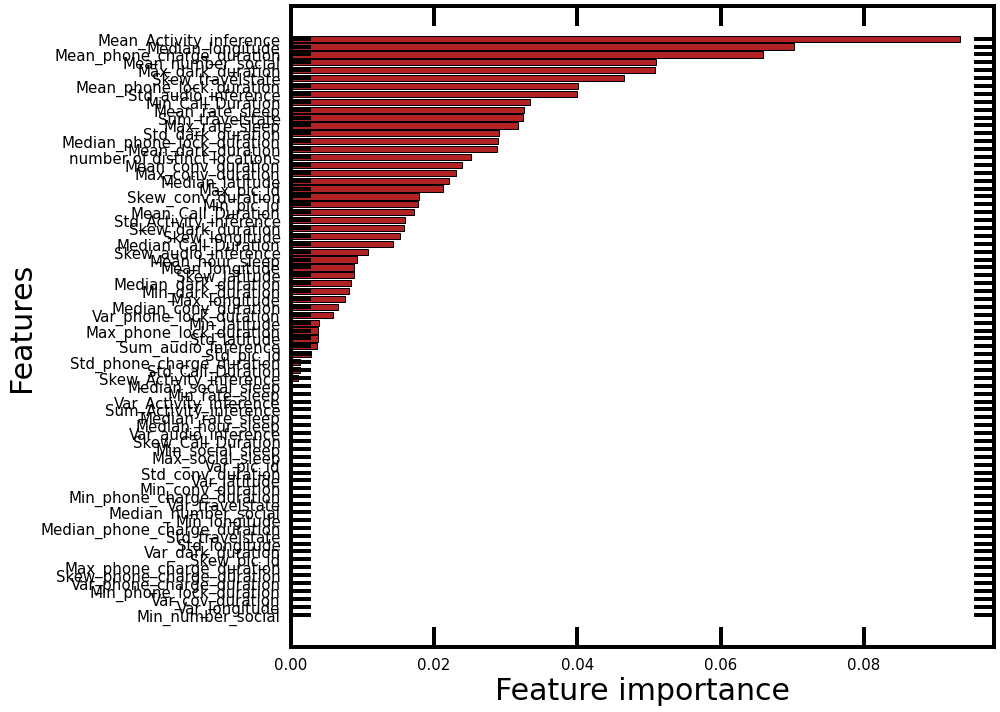

In [29]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tree['Features'], ordered_feat_imp_tree['Importance'], ec='black', color='firebrick')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=15)

plt.tight_layout()

In [30]:
xgb_model = XGBClassifier(booster = 'gblinear', use_label_encoder=False)
xgb_linear_parameters = {'updater': ['shotgun', 'coord_descent'],
                       'feature_selector': ['cyclic', 'shuffle'],
                        'lambda':[1, 0.1, 0.01], 'alpha':[1, 0.1, 0.01]}

In [31]:
%%time
xgb_linear = GridSearchCV(xgb_model, xgb_linear_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_linear.fit(X_train, y_train, eval_metric= 'logloss')
xgb_linear_best = xgb_linear.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_linear_best.predict(X_val)))

print('\n')
print('Best estimator:', xgb_linear.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        42
           1       0.00      0.00      0.00         5

    accuracy                           0.89        47
   macro avg       0.45      0.50      0.47        47
weighted avg       0.80      0.89      0.84        47



Best estimator: XGBClassifier(alpha=1, base_score=0.5, booster='gblinear',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, feature_selector='cyclic', gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              lambda=1, learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              random_state=0, reg_alpha=0,

The concept of feature importance is specific to decision trees, as the definition specifically refers to "splits"

In [32]:
xgb_model = XGBClassifier(booster = 'dart',use_label_encoder=False)
xgb_dart_parameters = {'sample_type': ['uniform'],
                      'normalize_type': ['tree'], 'rate_drop': [0.0, 0.1],
                       'skip_drop': [0.0, 0.1, 0.5], 
                      'eta': [0.1, 0.01], 'max_depth': [6, 8], 'lambda':[1, 0.1, 0.01], 
                       'alpha':[1, 0.1, 0.01]}

In [33]:
%%time
xgb_dart = GridSearchCV(xgb_model, xgb_dart_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_dart.fit(X_train, y_train, eval_metric='logloss')
xgb_dart_best = xgb_dart.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_dart_best.predict(X_val)))

print('\n')
print('Best estimator:', xgb_dart.best_estimator_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        42
           1       0.00      0.00      0.00         5

    accuracy                           0.85        47
   macro avg       0.44      0.48      0.46        47
weighted avg       0.79      0.85      0.82        47



Best estimator: XGBClassifier(alpha=0.01, base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=1, learning_rate=0.100000001, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              normalize_type='tree', num_parallel_tree=1, random_state=0,
              rate_drop=0.0, reg_alpha

In [34]:
feat_importances_xgb_dart = pd.DataFrame(zip(important_features, 
                                             xgb_dart_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [35]:
#feat_importances_xgb_dart

In [36]:
feat_importances_xgb_dart.max()

Features      number of distinct locations
Importance                       0.0590301
dtype: object

In [37]:
ordered_feat_imp_dart = feat_importances_xgb_dart.sort_values(by= ['Importance'])
ordered_feat_imp_dart = ordered_feat_imp_dart.reset_index()

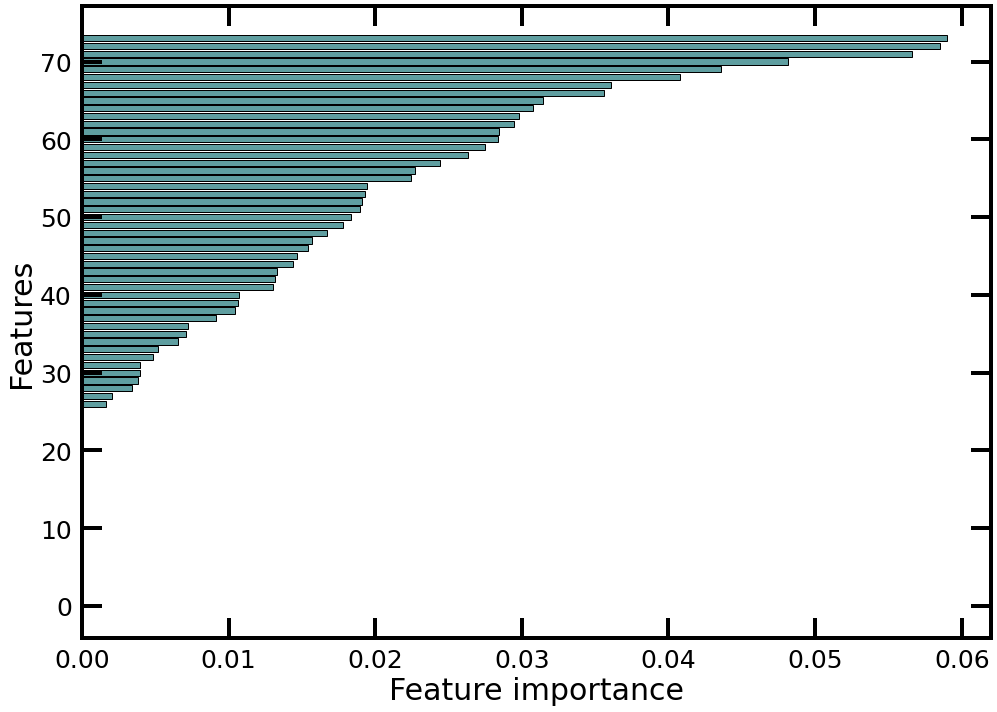

In [38]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_dart.index, ordered_feat_imp_dart['Importance'], ec='black', 
         color='cadetblue')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=25)

plt.tight_layout()
#fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/xgb_dart_feat_imp_with_txt_no_call.svg', bbox_inches='tight')

# TabNet:

In [39]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [134]:
clf1 = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                        n_d=8, n_a=8, n_steps=3, 
                        gamma=1.3, n_independent=3, n_shared=4, epsilon=1e-15, 
                        momentum=0.01, lambda_sparse=0.001, seed=0, clip_value=2, verbose=1, 
                       optimizer_params={'lr': 1e-3, 'weight_decay': 1e-3},
                        scheduler_params={'step_size':50,
                                         "gamma":0.90},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


In [135]:
clf1.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=1000 , patience=70,
    loss_fn = torch.nn.CrossEntropyLoss(),
    batch_size=256, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 0.96908 | train_accuracy: 0.20561 | valid_accuracy: 0.23404 |  0:00:00s
epoch 1  | loss: 0.88469 | train_accuracy: 0.20561 | valid_accuracy: 0.2766  |  0:00:00s
epoch 2  | loss: 0.99884 | train_accuracy: 0.19626 | valid_accuracy: 0.25532 |  0:00:00s
epoch 3  | loss: 0.85222 | train_accuracy: 0.16822 | valid_accuracy: 0.23404 |  0:00:00s
epoch 4  | loss: 0.75499 | train_accuracy: 0.16822 | valid_accuracy: 0.25532 |  0:00:00s
epoch 5  | loss: 0.84571 | train_accuracy: 0.19626 | valid_accuracy: 0.19149 |  0:00:00s
epoch 6  | loss: 0.7791  | train_accuracy: 0.18692 | valid_accuracy: 0.17021 |  0:00:00s
epoch 7  | loss: 0.78347 | train_accuracy: 0.2243  | valid_accuracy: 0.19149 |  0:00:00s
epoch 8  | loss: 0.87399 | train_accuracy: 0.20561 | valid_accuracy: 0.23404 |  0:00:01s
epoch 9  | loss: 0.89365 | train_accuracy: 0.2243  | valid_accuracy: 0.23404 |  0:00:01s
epoch 10 | loss: 0.87712 | train_accuracy: 0.25234 | valid_accuracy: 0.23404 |  0:00:01s
epoch 11 | loss: 0.88

epoch 93 | loss: 0.60434 | train_accuracy: 0.81308 | valid_accuracy: 0.74468 |  0:00:14s
epoch 94 | loss: 0.77914 | train_accuracy: 0.83178 | valid_accuracy: 0.74468 |  0:00:14s
epoch 95 | loss: 0.74787 | train_accuracy: 0.83178 | valid_accuracy: 0.74468 |  0:00:14s
epoch 96 | loss: 0.68401 | train_accuracy: 0.84112 | valid_accuracy: 0.74468 |  0:00:14s
epoch 97 | loss: 0.60977 | train_accuracy: 0.84112 | valid_accuracy: 0.74468 |  0:00:14s
epoch 98 | loss: 0.6958  | train_accuracy: 0.83178 | valid_accuracy: 0.74468 |  0:00:15s
epoch 99 | loss: 0.67321 | train_accuracy: 0.82243 | valid_accuracy: 0.74468 |  0:00:15s
epoch 100| loss: 0.61724 | train_accuracy: 0.82243 | valid_accuracy: 0.7234  |  0:00:15s
epoch 101| loss: 0.64599 | train_accuracy: 0.82243 | valid_accuracy: 0.7234  |  0:00:15s
epoch 102| loss: 0.71209 | train_accuracy: 0.82243 | valid_accuracy: 0.7234  |  0:00:15s
epoch 103| loss: 0.76394 | train_accuracy: 0.82243 | valid_accuracy: 0.7234  |  0:00:15s
epoch 104| loss: 0.65

epoch 186| loss: 0.58614 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:27s
epoch 187| loss: 0.56645 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:27s
epoch 188| loss: 0.63664 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:28s
epoch 189| loss: 0.61599 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:28s
epoch 190| loss: 0.54773 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:28s
epoch 191| loss: 0.61991 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:28s
epoch 192| loss: 0.60679 | train_accuracy: 0.85981 | valid_accuracy: 0.80851 |  0:00:28s
epoch 193| loss: 0.65476 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:28s
epoch 194| loss: 0.60976 | train_accuracy: 0.85981 | valid_accuracy: 0.82979 |  0:00:28s
epoch 195| loss: 0.53633 | train_accuracy: 0.85981 | valid_accuracy: 0.80851 |  0:00:28s
epoch 196| loss: 0.55082 | train_accuracy: 0.85981 | valid_accuracy: 0.80851 |  0:00:29s
epoch 197| loss: 0.64

In [80]:
preds_valid = clf1.predict(X_val)
valid_acc = accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.851063829787234


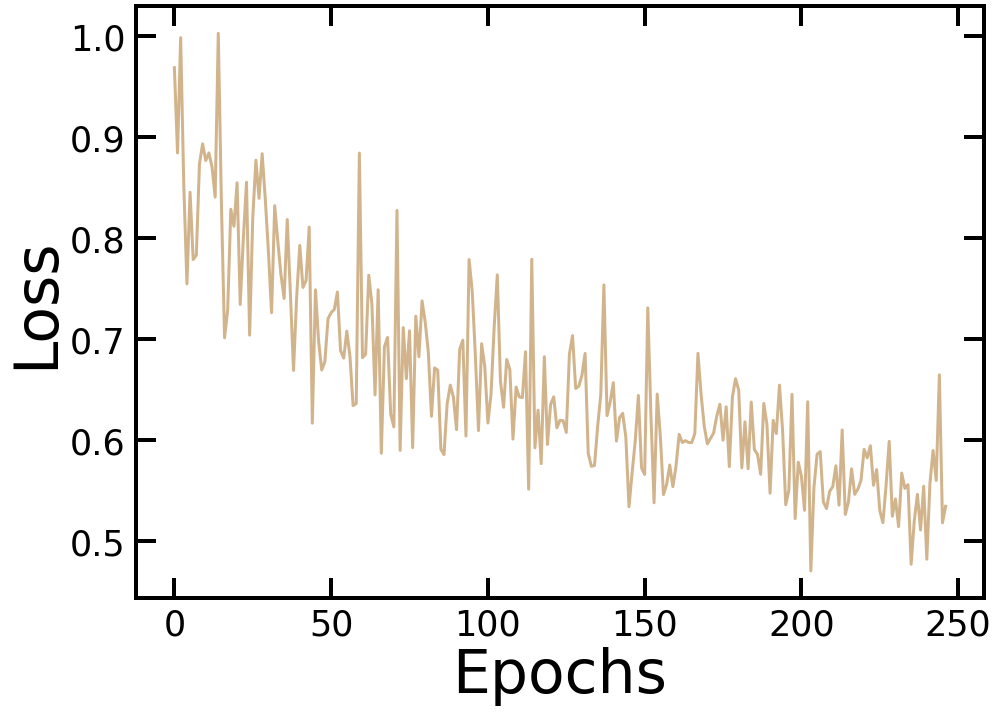

In [114]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['loss'], linewidth=3, color='tan')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Loss', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_loss_with_txt_call.svg', bbox_inches='tight')

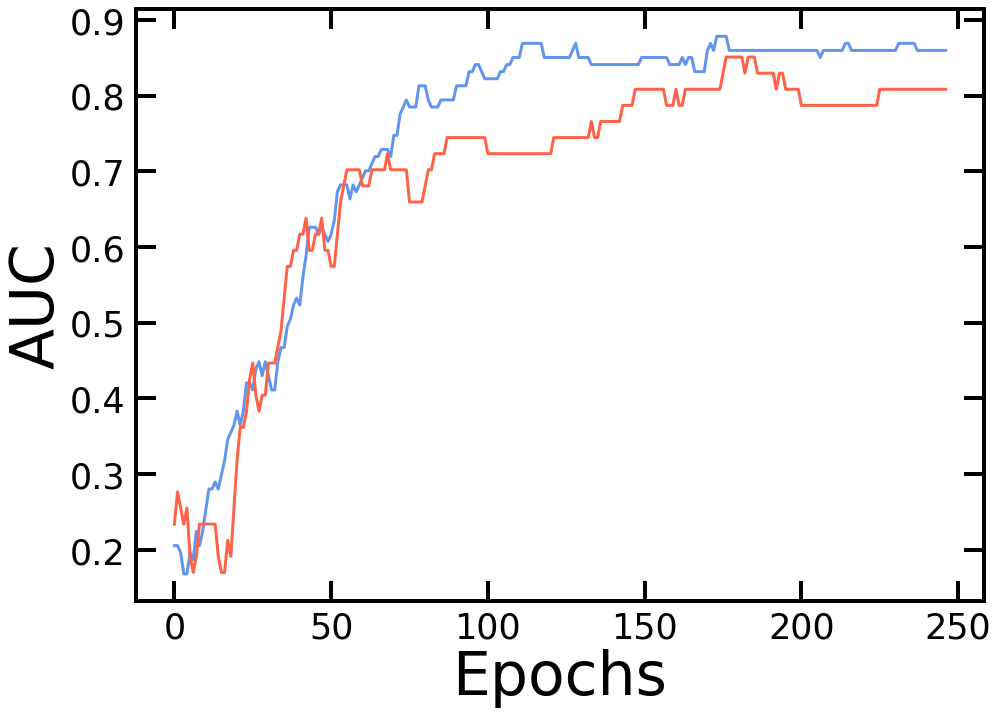

In [116]:

fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['train_accuracy'], linewidth=3, color = 'cornflowerblue')
axs.plot(clf1.history['valid_accuracy'], linewidth=3, color = 'tomato')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('AUC', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)
#legend = axs.legend(borderpad=1, labelspacing=2, fontsize=15)
#legend.get_frame().set_linewidth(2.5)
#legend.get_frame().set_edgecolor('black')

axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_acc_with_txt_call.svg', bbox_inches='tight')

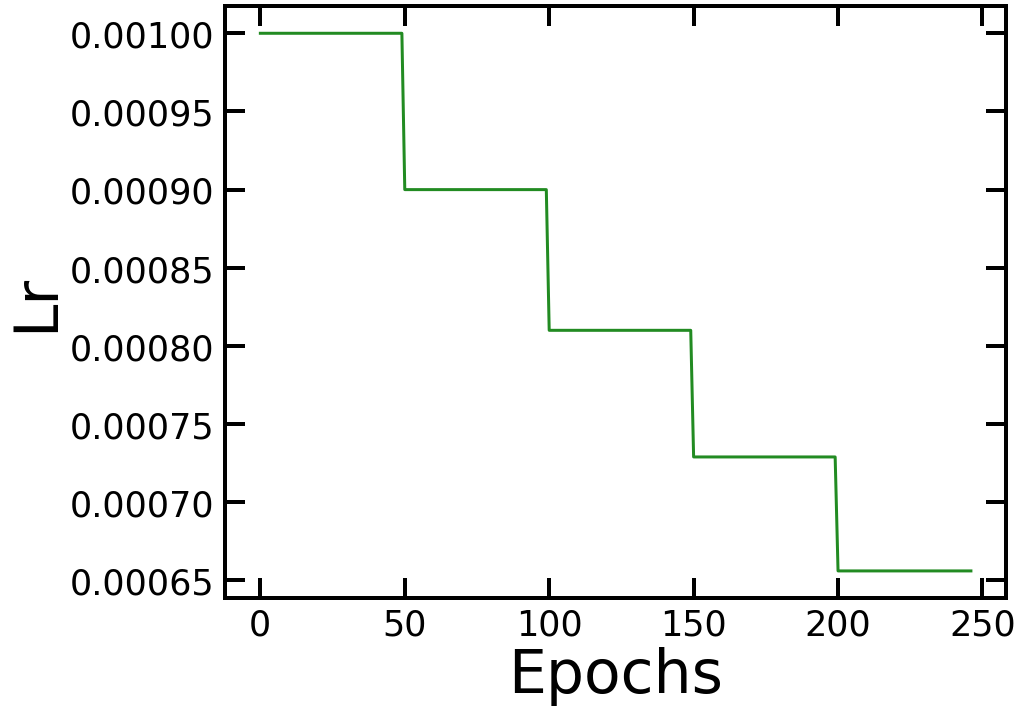

In [117]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['lr'], linewidth=3, color = 'forestgreen')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Lr', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_lr_with_txt_call.svg', bbox_inches='tight')

In [136]:
feat_importances_tabnet = pd.DataFrame(zip(important_features, 
                                             clf1.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [139]:
feat_importances_tabnet[:50]

,Features,Importance
0,Mean_Call_Duration,0.020773
1,Std_Call_Duration,0.009616
2,Median_Call_Duration,0.014384
3,Min_Call_Duration,0.029948
4,Skew_Call_Duration,0.011093
5,Mean_Activity_inference,0.014120
6,Std_Activity_inference,0.008105
7,Skew_Activity_inference,0.018752
8,Var_Activity_inference,0.008303
9,Sum_Activity_inference,0.009295


In [98]:
ordered_feat_imp_tabnet = feat_importances_tabnet.sort_values(by = ['Importance'])
ordered_feat_imp_tabnet = ordered_feat_imp_tabnet.reset_index()

In [133]:
ordered_feat_imp_tabnet

,index,Features,Importance
0,50,Var_phone_charge_duration,0.004113
1,47,Min_phone_charge_duration,0.004781
2,38,Skew_longitude,0.005122
3,59,Max_pic_id,0.005388
4,11,Skew_audio_inference,0.005763
...,...,...,...
69,45,Std_phone_charge_duration,0.029555
70,26,Skew_dark_duration,0.029647
71,3,Min_Call_Duration,0.029948
72,40,Var_latitude,0.037923


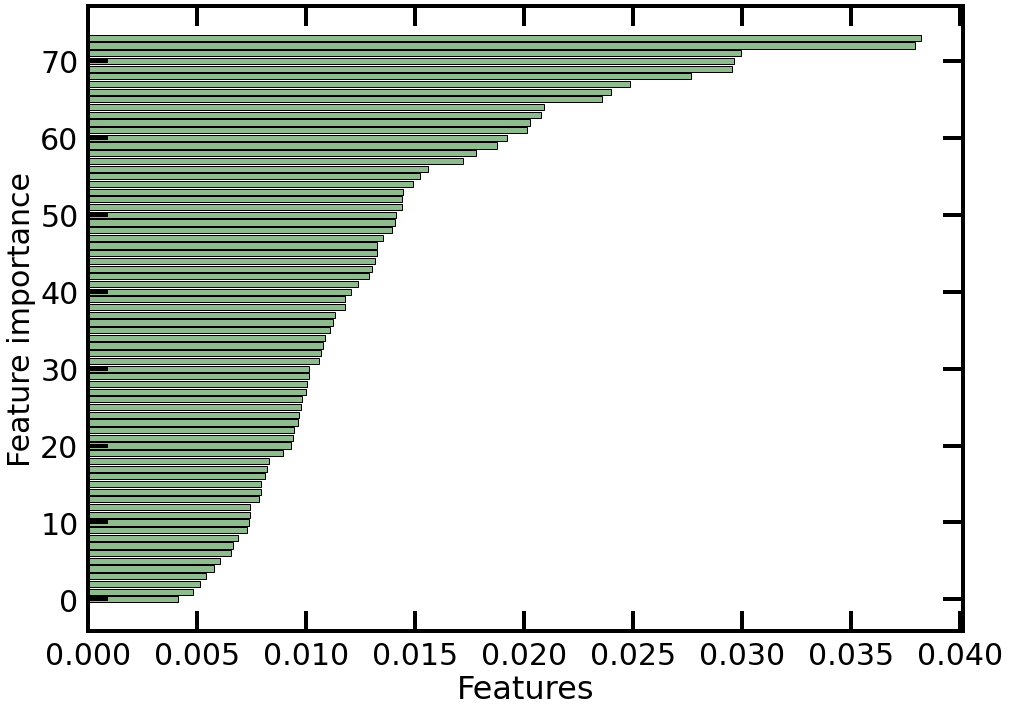

In [99]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tabnet.index, ordered_feat_imp_tabnet['Importance'], 
        ec='black', color='darkseagreen')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Features', fontsize=32)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=30)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/tabnet_feat_imp_with_txt_call.svg', bbox_inches='tight')

In [105]:
explain_matrix, masks = clf1.explain(X_val)

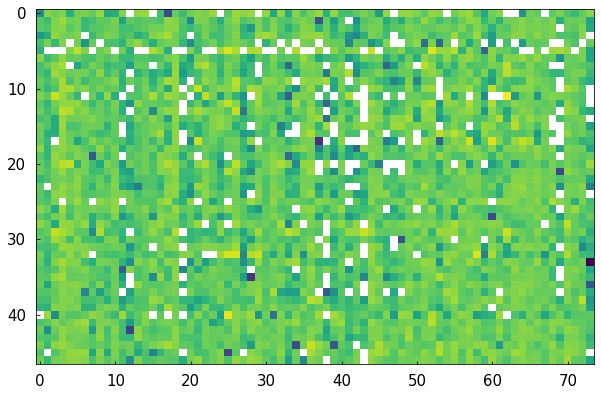

In [106]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.tick_params(which='both', direction="in", pad=10)
axs.tick_params(labelsize=15)
axs.imshow(np.log10(explain_matrix))

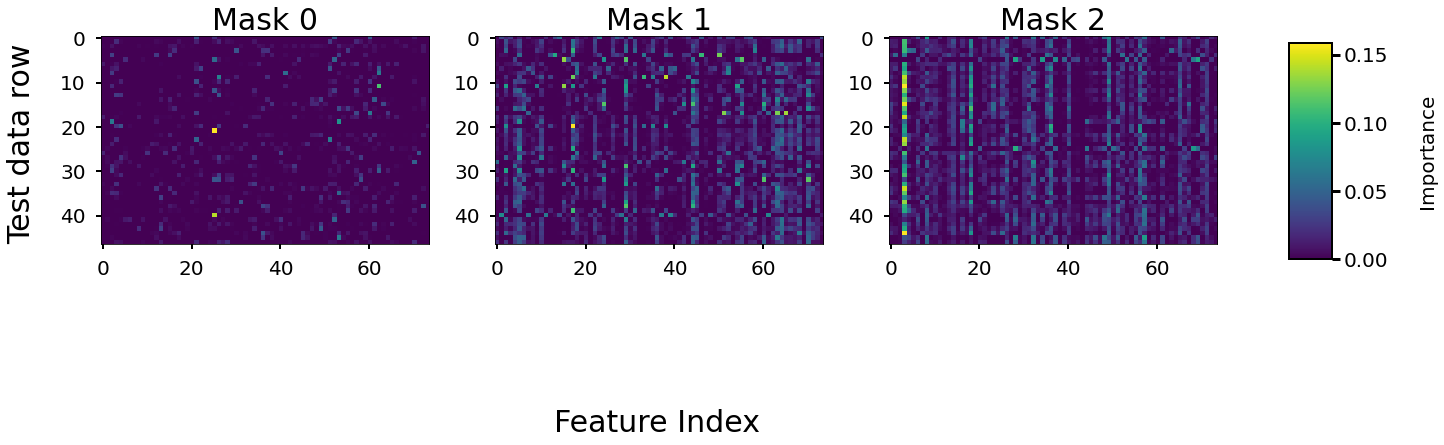

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    
    #axs[i].set_ylabel('Test Data Row', fontsize=30)
    #axs[i].set_xlabel('Feature index', fontsize=30)

    axs[i].tick_params(which='both', direction="out", pad=10,length=5, width=2)
    axs[i].tick_params(labelsize=20)
    im = axs[i].imshow(masks[i])
    axs[i].set_title(f"Mask {i}", fontsize=30)
    
fig.text(0.44, 0.3, 'Feature Index', fontsize=30)
fig.text(0.06, 0.5, 'Test data row', va='center', rotation='vertical', fontsize=30)

cax = fig.add_axes([0.95, 0.42, 0.03, 0.15])
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=20, length=8, width=3)
cb.outline.set_linewidth(2)
cb.set_label('Importance', fontsize = 20, rotation = 'vertical', labelpad=30)
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_masks_with_txt_call.svg', bbox_inches='tight')

In [164]:
#clf2 = TabNetClassifier()
#clf2_params = {'optimizer_fn':[torch.optim.Adam],
 #              'n_d': [8, 64], 'n_a': [8,64],
  #           'optimizer_params':[dict(lr=2e-2)],
   #            'n_independent': [2,3],
    #           'n_shared': [2,3],
     #          'n_steps':[3,5], 'momentum':[0.02, 0.05, 0.1, 0.2],
      #       'scheduler_params':[{"gamma":0.9}, {"gamma":0.7}, {"gamma":0.8}],
       #      'scheduler_fn': [torch.optim.lr_scheduler.ExponentialLR],
        #     'mask_type':['entmax']}
    
#clf_grid = GridSearchCV(clf2, clf2_params, scoring = sklearn.metrics.accuracy_score,
 #                       refit=True, n_jobs = -1, verbose=1)
#clf_grid.fit(
 #   X_train,y_train,
  #  eval_set=[(X_train, y_train), (X_val, y_val)],
   # eval_name=['train', 'valid'],
    #eval_metric=['auc'],
    #max_epochs=1000 , patience=50,
    #batch_size=256, virtual_batch_size=128,
    #num_workers=0,
    #weights=1,
    #drop_last=False
#)

In [165]:
#print('Best estimator:', clf_grid.best_estimator_)